In [1]:
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt

from mining.generative import SocialGenerativeModel, UpdateDist

  0%|          | 0/500 [00:00<?, ?it/s]/home/ben/Projects/phd/repos/mining/mining/generative.py:34: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  self.posts = pd.concat([self.posts, pd.DataFrame([new_post], index=[id])])
/home/ben/Projects/phd/repos/mining/mining/generative.py:46: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  self.comments = pd.concat([self.comments, pd.DataFrame([new_comment], index=[id])])
  1%|          | 3/500 [00:00<01:21,  6.13it/s]/home/ben/Projects/phd/repos/mining/mining/generative.py:34: FutureWarning: The behavior of array con

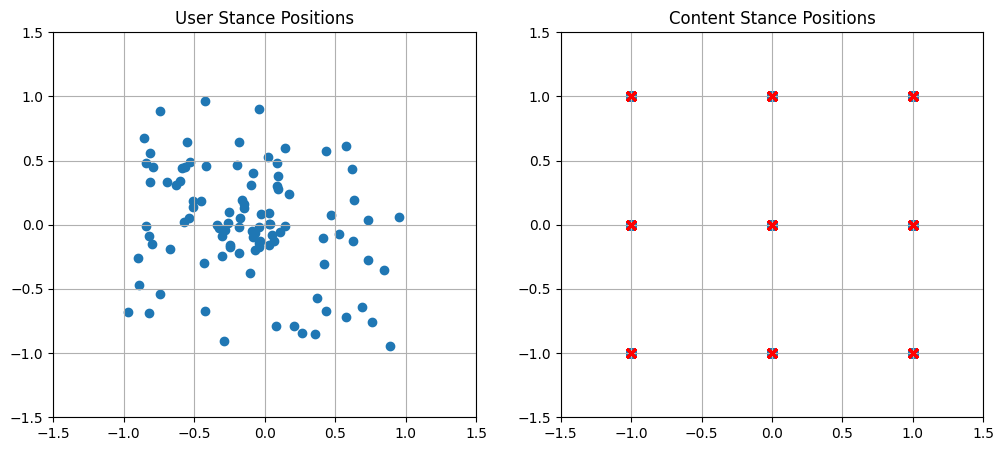

In [2]:
num_steps = 500
num_users = 100
social_context = SocialGenerativeModel(
    num_users=num_users, 
    sbc_exponent_loc=1.0,
    sbc_exponent_scale=0.1,
    comment_prob=0.2, 
    sus_loc=0.99, 
    sus_scale=0.1,
    seen_att_loc=0.001,
    reply_att_loc=0.05,
    post_att_loc=0.01,
    content_scale=0.5
)
interval = 5
fig, axes = plt.subplots(ncols=2, figsize=(12, 5))
ud = UpdateDist(social_context, axes[0], axes[1], num_steps=num_steps, interval=interval)
anim = FuncAnimation(fig, ud, frames=num_steps//interval, interval=10, blit=True)
HTML(anim.to_jshtml())

In [4]:
import gpytorch
import numpy as np
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import torch
import tqdm

from mining.datasets import GenerativeOpinionTimelineDataset
from mining import estimate

/home/ben/miniconda3/envs/polar-seeds/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def plot(
    X,
    y,
    plot_observed_data=False,
    plot_predictions=False,
    n_prior_samples=0,
    model=None,
    kernel=None,
    n_test=500,
    ax=None,
):
    x_start = torch.min(X) - 0.1 * (torch.max(X) - torch.min(X))
    x_end = torch.max(X) + 0.1 * (torch.max(X) - torch.min(X))
    artists = []
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    if plot_observed_data:
        observed_data_artists = ax.plot(X.numpy(), y.numpy(), "kx")
        artists.extend(observed_data_artists)
    if plot_predictions:
        Xtest = torch.linspace(x_start, x_end, n_test)  # test inputs
        # compute predictive mean and variance
        with torch.no_grad():
            if type(model) == gp.models.VariationalSparseGP or type(model) == gp.models.VariationalGP:
                mean, cov = model(Xtest, full_cov=True)
            else:
                mean, cov = model(Xtest, full_cov=True, noiseless=False)
        sd = cov.diag().sqrt()  # standard deviation at each input point x
        predictions_artists = ax.plot(Xtest.numpy(), mean.numpy(), "r", lw=2)  # plot the mean
        artists.extend(predictions_artists)
        fill_artist = ax.fill_between(
            Xtest.numpy(),  # plot the two-sigma uncertainty about the mean
            (mean - 2.0 * sd).numpy(),
            (mean + 2.0 * sd).numpy(),
            color="C0",
            alpha=0.3,
        )
        artists.append(fill_artist)
    if n_prior_samples > 0:  # plot samples from the GP prior
        Xtest = torch.linspace(x_start, x_end, n_test)  # test inputs
        noise = (
            model.noise
            if type(model) not in [gp.models.VariationalSparseGP, gp.models.VariationalGP]
            else model.likelihood.variance
        )
        cov = kernel.forward(Xtest) + noise.expand(n_test).diag()
        samples = dist.MultivariateNormal(
            torch.zeros(n_test), covariance_matrix=cov
        ).sample(sample_shape=(n_prior_samples,))
        samples_artist = ax.plot(Xtest.numpy(), samples.numpy().T, lw=2, alpha=0.4)
        artists.append(samples_artist)

    ax.set_xlim(x_start, x_end)
    return artists

def truncate(times, sequences):
    # hack to get nans
    nan_idx = torch.where(times != times)[0][0]
    return times[:nan_idx], sequences[:nan_idx]

In [5]:
dataset = GenerativeOpinionTimelineDataset(generative_model=social_context)

opinion_times, opinion_sequences, users, classifier_indices = dataset.get_data(start=0, end=dataset.max_time_step)
estimator = estimate.StanceEstimation(dataset.all_classifier_profiles)
estimator.set_stance(dataset.stance_columns[0])
X = torch.tensor(opinion_times).float()
max_x = torch.max(torch.nan_to_num(X, 0))
X_norm = X / max_x
y = torch.tensor(opinion_sequences).float()

In [8]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X_norm, y, likelihood)

[[<matplotlib.lines.Line2D at 0x7daba047d6d0>,

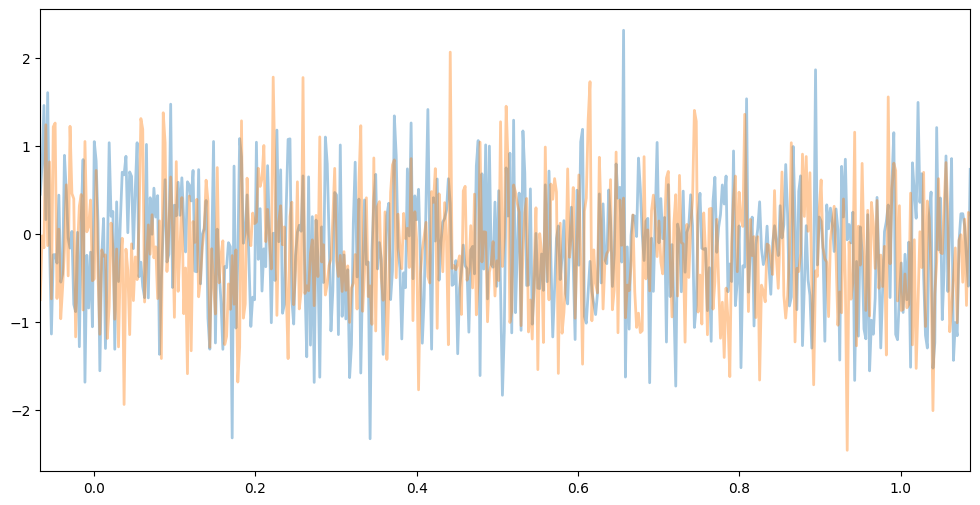

In [7]:
plot(X_single, y_single, model=gpr, kernel=kernel, n_prior_samples=2)

In [11]:
training_iter = 50

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(X_norm)
    # Calc loss and backprop gradients
    loss = -mll(output, y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

RuntimeError: You must train on the training inputs!

Text(0, 0.5, 'Loss')

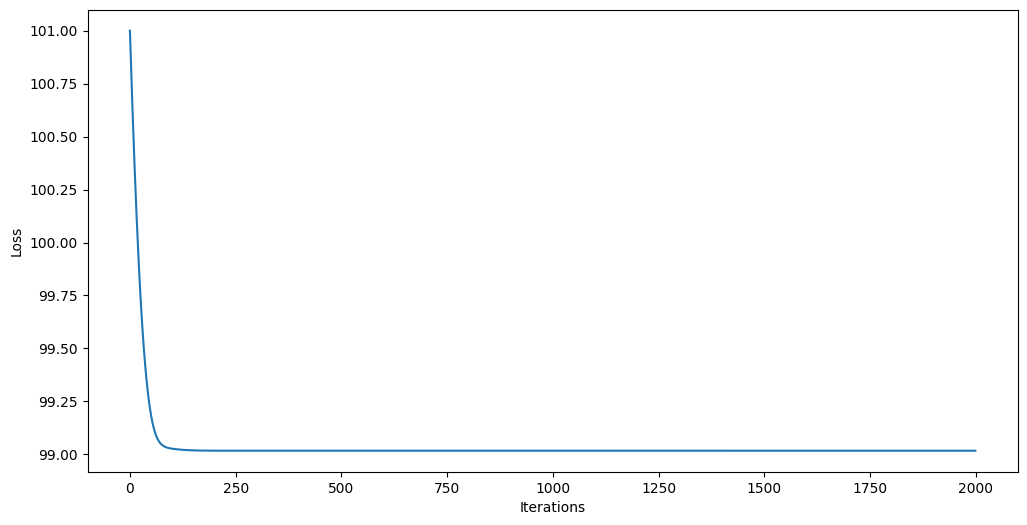

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(losses)
ax.set_xlabel("Iterations")
ax.set_ylabel("Loss")  # supress output text

In [10]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_x))

with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(X.numpy(), y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

In [27]:
num_users = X.shape[0]
num_opinions = y.shape[-1]
num_timesteps = 500
means = np.full((num_users, num_timesteps, num_opinions), np.nan)
for i in range(num_users):
    for j in range(num_opinions):
        kernel = gp.kernels.RBF(
            input_dim=1, variance=torch.tensor(0.1), lengthscale=torch.tensor(2)
        )
        X_single, y_single = truncate(X_norm[i,:], y[i,:,j])
        gpr = gp.models.GPRegression(X_single, y_single, kernel, noise=torch.tensor(0.5))
        optimizer = torch.optim.Adam(gpr.parameters(), lr=0.005)
        loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
        losses = []
        variances = []
        lengthscales = []
        noises = []
        num_steps = 2000
        print(f"Starting training for user {i}, opinion {j}")
        for _ in tqdm.tqdm(range(num_steps)):
            variances.append(gpr.kernel.variance.item())
            lengthscales.append(gpr.kernel.lengthscale.item())
            optimizer.zero_grad()
            loss = loss_fn(gpr.model, gpr.guide)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        x_start = max(torch.min(X_single) - 0.1 * (torch.max(X_single) - torch.min(X_single)), 0.)
        x_end = min(torch.max(X_single) + 0.1 * (torch.max(X_single) - torch.min(X_single)), 1.)
        n_test = int((x_end - x_start) * num_timesteps)
        Xtest = torch.linspace(x_start, x_end, n_test)  # test inputs
        # compute predictive mean and variance
        with torch.no_grad():
            if type(gpr) == gp.models.VariationalSparseGP or type(gpr) == gp.models.VariationalGP:
                mean, cov = gpr(Xtest, full_cov=True)
            else:
                mean, cov = gpr(Xtest, full_cov=True, noiseless=False)

        means[i, int(x_start * n_test):int(x_end * n_test), j] = mean

        

Starting training for user 0, opinion 0
































































































100%|██████████| 2000/2000 [00:09<00:00, 200.67it/s]
/tmp/ipykernel_692575/4064221817.py:40: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  means[i, int(x_start * n_test):int(x_end * n_test), j] = mean


Starting training for user 0, opinion 1





































































































100%|██████████| 2000/2000 [00:10<00:00, 191.64it/s]


Starting training for user 1, opinion 0








































































































100%|██████████| 2000/2000 [00:10<00:00, 183.90it/s]


Starting training for user 1, opinion 1













































































































100%|██████████| 2000/2000 [00:11<00:00, 172.13it/s]


Starting training for user 2, opinion 0





























































































































100%|██████████| 2000/2000 [00:13<00:00, 146.80it/s]


Starting training for user 2, opinion 1































































































































100%|██████████| 2000/2000 [00:13<00:00, 143.69it/s]


Starting training for user 3, opinion 0




































































































100%|██████████| 2000/2000 [00:10<00:00, 194.50it/s]


Starting training for user 3, opinion 1
































































































100%|██████████| 2000/2000 [00:09<00:00, 201.37it/s]


Starting training for user 4, opinion 0





























































































100%|██████████| 2000/2000 [00:09<00:00, 210.51it/s]


Starting training for user 4, opinion 1
































































































100%|██████████| 2000/2000 [00:09<00:00, 201.42it/s]


Starting training for user 5, opinion 0

















































































































100%|██████████| 2000/2000 [00:12<00:00, 163.54it/s]


Starting training for user 5, opinion 1

















































































































100%|██████████| 2000/2000 [00:12<00:00, 163.06it/s]


IndexError: index 0 is out of bounds for dimension 0 with size 0